In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os
import re


————————Experiment extract data————————

In [6]:
folder_path_1 = '/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250602/Si_Air/data'
folder_path_2 = '/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250602/Si_H2O/data'

In [7]:
def extract_angle(filename):
    # Look for the last number at the end of the filename, even if there's no extension
    match = re.search(r"(\d+(?:\.\d+)?)\s*(?=\s*$|\.\w+$)", filename)
    return float(match.group(1)) if match else None

def extract_data_from_single_file(file_path):
    try:
        # Read comma-separated values
        df = pd.read_csv(file_path, sep=',', header=None, names=['wavenumber', 'R'], encoding='ISO-8859-1')
        return df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None
    
# Function to iterate through the folder and extract data for different angles
def read_dpt_files_in_folder(folder_path):
    data = {}
    for file in os.listdir(folder_path):
        angle = extract_angle(file)
        if angle is not None:
            # Construct the full file path
            file_path = os.path.join(folder_path, file)
            # Extract data from the file
            df = extract_data_from_single_file(file_path)
            if df is not None:
                data[angle] = df
        
            
            
    return data

In [8]:
data_y1 = read_dpt_files_in_folder(folder_path_1)
data_y2 = read_dpt_files_in_folder(folder_path_2)

In [9]:
# --- !! WAVENUMERS TO BE USED ---
exp_wavenumbers = data_y1[5]['wavenumber'].values


In [10]:
def compute_normed_ratio(data_y1, data_y2, window):
    data_ratio = {}
    data_ratio_smoothed = {}

    for angle in data_y1:
        if angle in data_y2:
            df1 = data_y1[angle]  # Denominator: Si-air
            df2 = data_y2[angle]  # Numerator: Si-H2O

            # Ensure wavenumbers match
            if np.allclose(df1['wavenumber'], df2['wavenumber']):
                wn = df1['wavenumber'].values
                R_air = df1['R'].values
                R_water = df2['R'].values
                ratio = np.where(R_air != 0, R_water / R_air, np.nan)

                # --- Smoothing ---
                ratio_smooth = []
                for i, center_wn in enumerate(wn):
                    mask = (wn >= center_wn - window) & (wn <= center_wn + window)
                    valid = ~np.isnan(ratio[mask])
                    avg = np.mean(ratio[mask][valid]) if np.any(valid) else np.nan
                    ratio_smooth.append(avg)

                # --- Raw ratio DataFrame ---
                df_ratio = pd.DataFrame({
                    'wavenumber': wn,
                    'Normed R': ratio,
                    # 'R_Si-H2O': R_water,
                    # 'R_Si-air': R_air
                })

                # --- Smoothed ratio DataFrame ---
                df_ratio_smooth = pd.DataFrame({
                    'wavenumber': wn,
                    'Smoothed Normed R': ratio_smooth,  # Note: same column name!
                    # 'R_Si-H2O': R_water,
                    # 'R_Si-air': R_air
                })

                data_ratio[angle] = df_ratio
                data_ratio_smoothed[angle] = df_ratio_smooth

            else:
                print(f"Wavenumbers do not match at angle {angle}. Skipping.")
        else:
            print(f"Angle {angle} missing in data_y2. Skipping.")

    return data_ratio, data_ratio_smoothed


In [11]:
window = 50
data_normed, data_normed_smoothed = compute_normed_ratio(data_y1, data_y2,window)

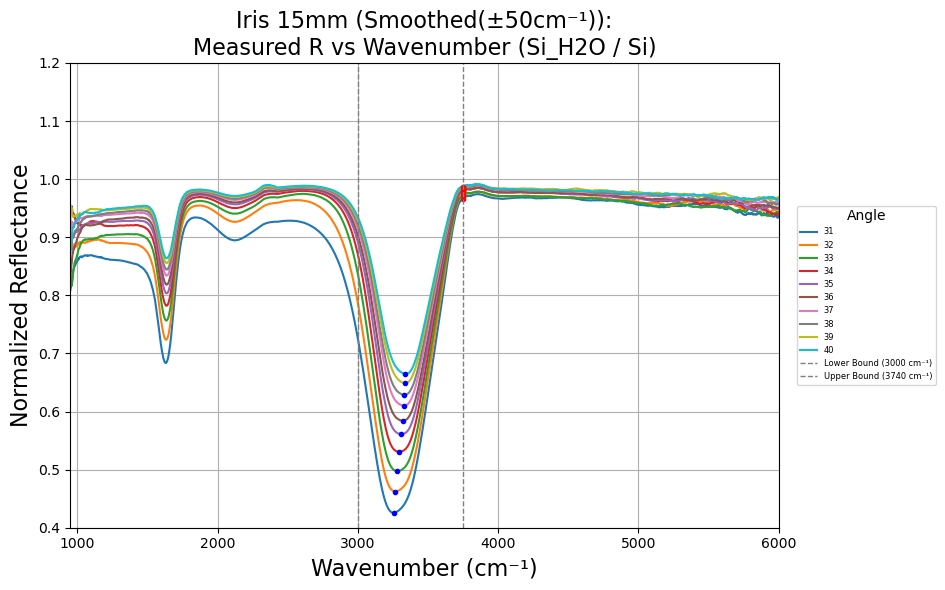

In [12]:
# --- SELECT angles
# selected_angles = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]  # Update this list as you wish
# selected_angles = np.round(np.arange(5,21, 1), 1)
# selected_angles = np.round(np.arange(21,31, 1), 1)
selected_angles = np.round(np.arange(31,41, 1), 1)
# selected_angles = np.round(np.arange(41,51, 1), 1)


# --- Plot reflectance vs wavenumber for selected angles ---
plt.figure(figsize=(12, 6))

for angle in selected_angles:
    if angle not in data_normed_smoothed:
        print(f"Warning: angle {angle}° not found in data_normed_smoothed.")
        continue

    df = data_normed_smoothed[angle]
    wavenumbers = df["wavenumber"].values
    reflectance = df["Smoothed Normed R"].values

    # Plot main curve
    plt.plot(wavenumbers, reflectance, label=angle)

    # Find max and min within the visible x-range
    mask = (wavenumbers >= 3000) & (wavenumbers <= 3747)
    wn_crop = wavenumbers[mask]
    R_crop = reflectance[mask]

    max_idx = np.argmax(R_crop)
    min_idx = np.argmin(R_crop)
    wn_max, R_max = wn_crop[max_idx], R_crop[max_idx]
    wn_min, R_min = wn_crop[min_idx], R_crop[min_idx]
    # print(wn_max, R_max)
    # Plot max and min points
    plt.plot(wn_max, R_max, 'ro', markersize=3)  # red dot for max
    plt.plot(wn_min, R_min, 'bo', markersize=3)  # blue dot for min

# --- Customize plot ---
plt.title(
    f"Iris 15mm (Smoothed(±{window}cm⁻¹)):\n"
    "Measured R vs Wavenumber (Si_H2O / Si)",
    fontsize=16
)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("Normalized Reflectance", fontsize=16)
plt.xlim(950, 6000)
plt.ylim(0.4, 1.2)
plt.grid(True)
# Add vertical lines at the mask bounds
plt.axvline(3000, color='gray', linestyle='--', linewidth=1, label='Lower Bound (3000 cm⁻¹)')
plt.axvline(3747, color='gray', linestyle='--', linewidth=1, label='Upper Bound (3740 cm⁻¹)')

plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=6)
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust right margin to make space for legend
plt.show()


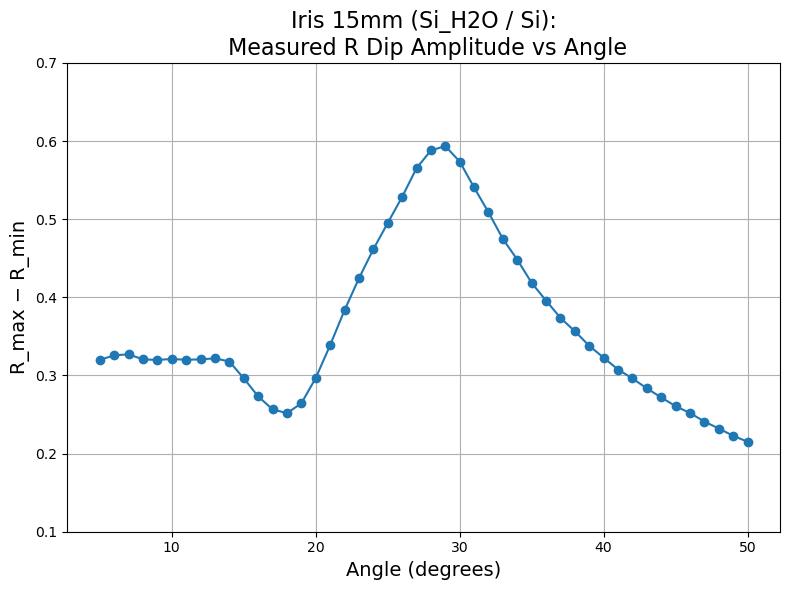

In [13]:
# --- Compute and store amplitudes for each angle ---

amplitudes_exp = []

for angle in np.arange(5, 51):  # Angles from 5 to 50 inclusive
    angle = round(angle, 1)
    if angle not in data_normed_smoothed:
        continue

    df = data_normed_smoothed[angle]
    wavenumbers = df["wavenumber"].values
    reflectance = df["Smoothed Normed R"].values

    # Restrict to target wavenumber range
    mask = (wavenumbers >= 3000) & (wavenumbers <= 3747)
    wn_crop = wavenumbers[mask]
    R_crop = reflectance[mask]

    if len(R_crop) == 0:
        continue

    R_max = np.max(R_crop)
    R_min = np.min(R_crop)
    amplitude = R_max - R_min

    
    amplitudes_exp.append(amplitude)

# --- Plot amplitude vs angle ---
plt.figure(figsize=(8, 6))
plt.plot(sorted(data_normed.keys()), amplitudes_exp, marker='o', linestyle='-', label='Experiment')

plt.title(f"Iris 15mm (Si_H2O / Si):\n Measured R Dip Amplitude vs Angle",fontsize=16)
plt.xlabel("Angle (degrees)", fontsize=14)
plt.ylabel("R_max − R_min", fontsize=14)
plt.ylim(0.1, 0.7)
plt.grid(True)
plt.tight_layout()
plt.show()


--------------------------------------------

————————Theory calculations extract data————————

In [14]:
# Define the path to your Excel file
file_path = "/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250328/H2O refractive index.xlsx"

# Read the Excel file
df_full = pd.read_excel(file_path, engine='openpyxl', nrows=168)

# Extract the 2nd, 3rd, and 4th columns (indexing starts from 0)
water_nk = df_full.iloc[:, [1, 2, 3]]

# Rename the columns for clarity
water_nk.columns = ["Wavenumber (cm⁻¹)", "n (real)", "k (imag)"]

————————Theory calculations————————

In [15]:
# Constants for Si (real index only)
n1 = 3.417  # Si
k1 = 0.0
n1_complex = n1 + 1j * k1


# Create custom angle list
angles_deg = np.concatenate([np.arange(2, 50.1, 0.1)])
angles_rad = np.radians(angles_deg)

# Prepare output dictionary
angle_dict = {}

# Loop over angles
for angle_deg, theta_i in zip(angles_deg, angles_rad):
    cos_theta_i = np.cos(theta_i)
    sin_theta_i = np.sin(theta_i)

    Rnorm_list = []
    wavenumbers = []

    # --- Pre-compute Si–Air Fresnel reflection coefficients (complex) ---
    n_air = 1 + 0j
    sin_theta_t_air = (n1_complex / n_air) * sin_theta_i
    cos_theta_t_air = np.sqrt(1 - sin_theta_t_air**2)

    rs_air = (n1_complex * cos_theta_i - n_air * cos_theta_t_air) /(n1_complex * cos_theta_i + n_air * cos_theta_t_air)
    rp_air = (n1_complex * cos_theta_t_air - n_air * cos_theta_i) / (n1_complex * cos_theta_t_air + n_air * cos_theta_i)

    denom = abs(rs_air)**2 + abs(rp_air)**2  # Denominator for normalization

    # Loop over each row in water_nk
    for _, row in water_nk.iterrows():
        wn = row[0]
        n2_complex = row[1] + 1j * row[2]  # water complex index

        # Compute transmission angle using Snell's law
        sin_theta_t = (n1_complex / n2_complex) * sin_theta_i
        cos_theta_t = np.sqrt(1 - sin_theta_t**2)

        # Compute complex Fresnel coefficients for Si–water
        rs_water = (n1_complex * cos_theta_i - n2_complex * cos_theta_t) / (n1_complex * cos_theta_i + n2_complex * cos_theta_t)
        rp_water = (n1_complex * cos_theta_t - n2_complex * cos_theta_i) / (n1_complex * cos_theta_t + n2_complex * cos_theta_i)

        num = abs(rs_water)**2 + abs(rp_water)**2  # Numerator

        Rnorm = num / denom  # Normalized reflectivity

        Rnorm_list.append(Rnorm)
        wavenumbers.append(wn)

    # Store in angle_dict
    R_data_df = pd.DataFrame({
        "wavenumber": wavenumbers,
        "Rnorm": Rnorm_list
    })
    angle_dict[angle_deg] = R_data_df


——————————Theory: Sliding average over angles———————————

In [16]:
angular_window = 6.34 # --- Angle Smoothing window  ---

In [17]:
# --- Extract sorted angle list and wavenumbers ---
angles_all = np.array(sorted(angle_dict.keys()))
wavenumbers = np.array(angle_dict[angles_all[0]]['wavenumber'].values)

# --- Create smoothed Rnorm matrix ---
Rnorm_smooth = []

for angle in angles_all:
    # Indices of angles within ±window degrees
    neighbor_mask = (angles_all >= angle - angular_window) & (angles_all <= angle + angular_window)
    neighbor_angles = angles_all[neighbor_mask]

    # Average Rnorm across neighbors
    Rnorm_avg = np.mean([angle_dict[a]['Rnorm'].values for a in neighbor_angles], axis=0)
    Rnorm_smooth.append(Rnorm_avg)

# Convert to array
Rnorm_smooth = np.array(Rnorm_smooth)

In [18]:
# !!! Theory dataset !!!
Rnorm_smooth_dict = dict(zip(angles_deg, Rnorm_smooth))

——————————Theory: plotting Sliding average over angles———————————

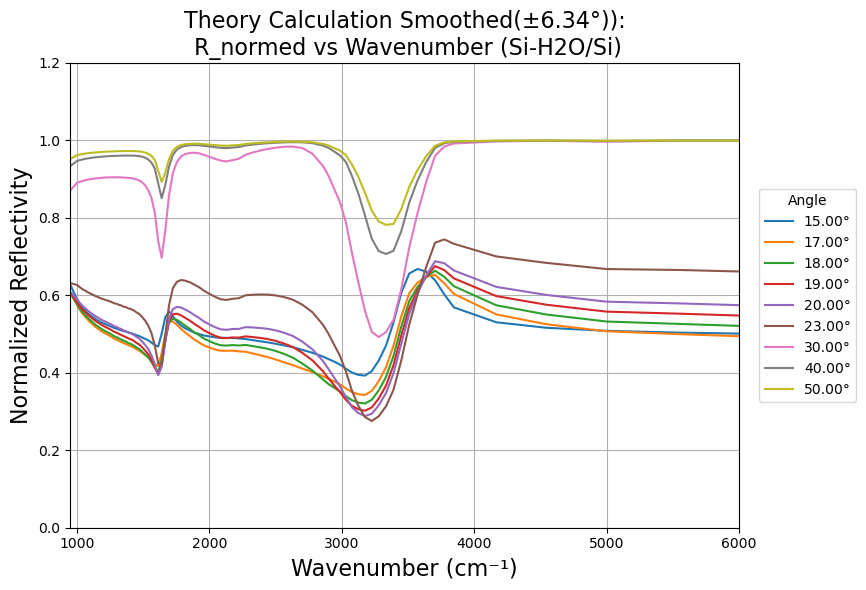

In [19]:
# R vs. wavenumber smoothed
# --- Select target angles (in degrees) ---
#target_angles = [22.2, 22.7, 23.3, 24.4, 25.6,33.5]    
target_angles = [15, 17,18, 19,20, 23, 30, 40, 50] 
# Match to closest available angles
matched_angle_indices = [np.argmin(np.abs(angles_all - a)) for a in target_angles]
matched_angle_values = [angles_all[i] for i in matched_angle_indices]

# --- Plot ---
plt.figure(figsize=(11, 6))

for idx, angle in zip(matched_angle_indices, matched_angle_values):
    #Rnorm_curve = Rnorm_smooth[idx, :]
    Rnorm_curve = Rnorm_smooth[idx, :]
    plt.plot(wavenumbers, Rnorm_curve, label=f"{angle:.2f}°")

# --- Customize plot ---
plt.title(f"Theory Calculation Smoothed(±{angular_window}°)):\n R_normed vs Wavenumber (Si-H2O/Si)", fontsize=16)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("Normalized Reflectivity", fontsize=16)
plt.xlim(950, 6000)
plt.ylim(0, 1.2)
plt.grid(True)
# Place legend outside
plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust right margin to make space for legend

plt.show()



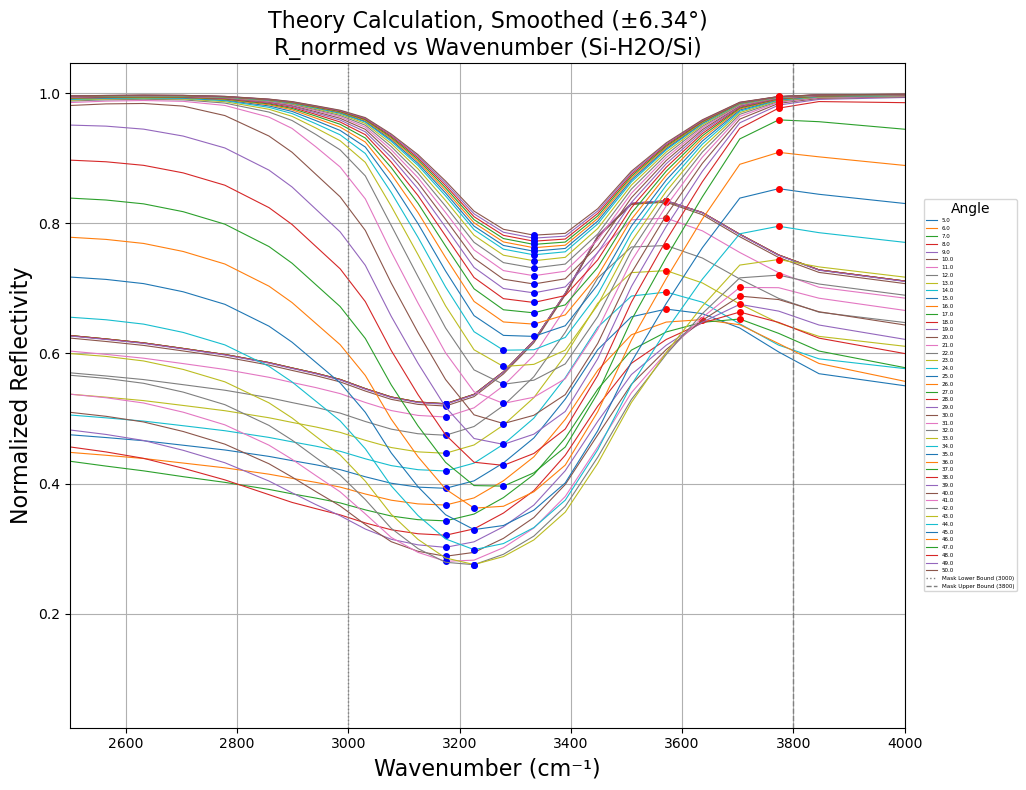

In [20]:
# --- Select target angles ---
target_angles = np.round(np.arange(5, 51, 1), 1)

# Match to closest available angles
matched_angle_indices = [np.argmin(np.abs(angles_all - a)) for a in target_angles]
matched_angle_values = [angles_all[i] for i in matched_angle_indices]

# --- Plot ---
plt.figure(figsize=(13, 8))

for idx, angle in zip(matched_angle_indices, matched_angle_values):
    Rnorm_curve = Rnorm_smooth[idx, :]

    # --- Fixed wavenumber mask for all angles ---
    lower_bound, upper_bound = 3000, 3800
    mask = (wavenumbers >= lower_bound) & (wavenumbers <= upper_bound)
    wn_crop = wavenumbers[mask]
    R_crop = Rnorm_curve[mask]

    # --- Find max and min in the range ---
    max_idx = np.argmax(R_crop)
    min_idx = np.argmin(R_crop)
    wn_max, R_max = wn_crop[max_idx], R_crop[max_idx]
    wn_min, R_min = wn_crop[min_idx], R_crop[min_idx]

    # --- Plot the main curve ---
    plt.plot(wavenumbers, Rnorm_curve, linewidth=0.8, label=f'{angle:.1f}')

    # --- Plot markers at max and min ---
    plt.plot(wn_max, R_max, 'ro', markersize=4)
    plt.plot(wn_min, R_min, 'bo', markersize=4)

# --- Customize plot ---
plt.title(f"Theory Calculation, Smoothed (±{angular_window}°)\nR_normed vs Wavenumber (Si-H2O/Si)", fontsize=16)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("Normalized Reflectivity", fontsize=16)
plt.xlim(2500, 4000)
plt.grid(True)

# Add vertical bounds for visual reference
plt.axvline(lower_bound, color='gray', linestyle=':', linewidth=1, label='Mask Lower Bound (3000)')
plt.axvline(upper_bound, color='gray', linestyle='--', linewidth=1, label='Mask Upper Bound (3800)')

plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=4)
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()


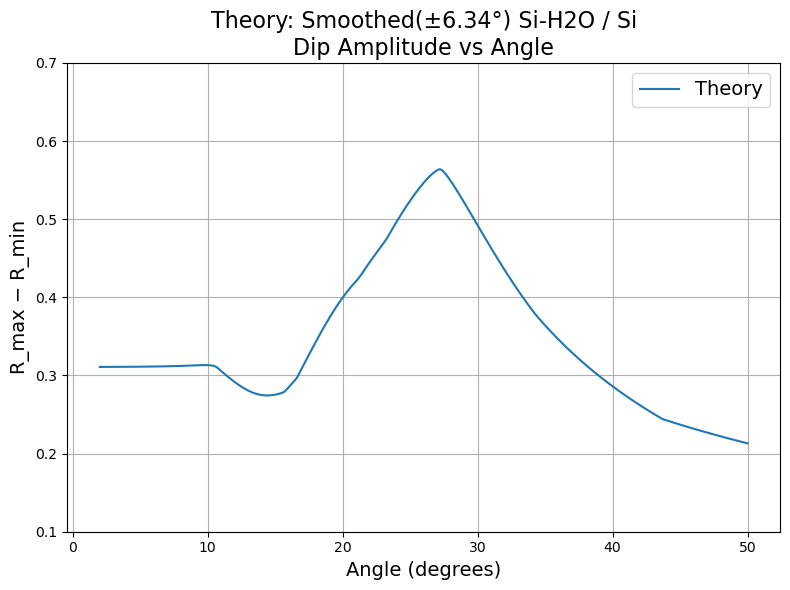

In [21]:
# --- Initialize storage ---
amplitudes_thr = []

# --- Fixed wavenumber mask range for all angles ---
lower_bound, upper_bound = 3000, 3800

# --- Loop through all angles in 0.1° steps ---
for angle in angles_deg:

    # Find the index corresponding to this angle
    idx = np.argmin(np.abs(angles_all - angle))
    Rnorm_curve = Rnorm_smooth[idx, :]

    # Apply fixed mask
    mask = (wavenumbers >= lower_bound) & (wavenumbers <= upper_bound)
    wn_crop = wavenumbers[mask]
    R_crop = Rnorm_curve[mask]

    if len(R_crop) == 0:
        amplitudes_thr.append(np.nan)
        continue

    R_max = np.max(R_crop)
    R_min = np.min(R_crop)
    amplitude = R_max - R_min

    amplitudes_thr.append(amplitude)

# --- Plot amplitude vs angle ---
plt.figure(figsize=(8, 6))
plt.plot(angles_deg, amplitudes_thr, linewidth=1.5, label='Theory')

plt.title(f"Theory: Smoothed(±{angular_window}°) Si-H2O / Si\nDip Amplitude vs Angle", fontsize=16)
plt.legend(fontsize=14)
plt.xlabel("Angle (degrees)", fontsize=14)
plt.ylabel("R_max − R_min", fontsize=14)
plt.ylim(0.1, 0.7)
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
np.array(sorted(data_normed.keys()))

array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.,
       18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
       44., 45., 46., 47., 48., 49., 50.])

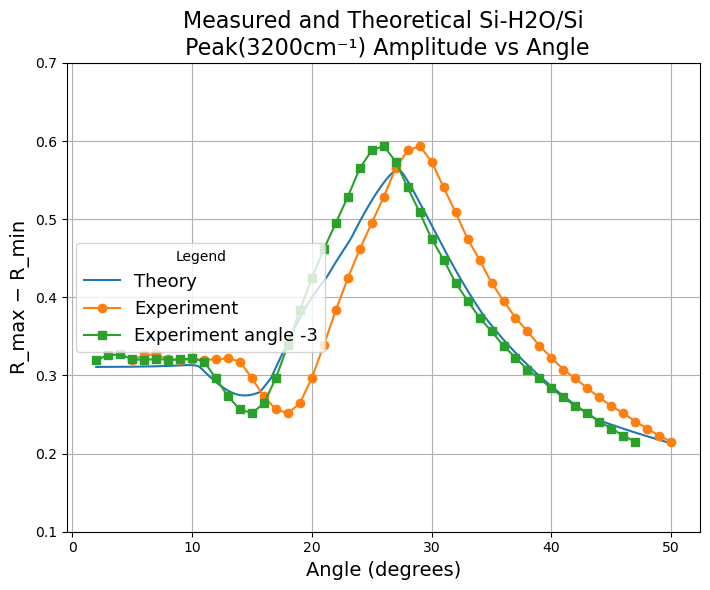

In [29]:
# --- Comparison ---
plt.figure(figsize=(9, 6))
plt.plot(angles_deg, amplitudes_thr, linewidth=1.5, label=f'Theory')
plt.plot(sorted(data_normed.keys()), amplitudes_exp, marker='o', linestyle='-', label='Experiment')
plt.plot(np.array(sorted(data_normed.keys()))-3, amplitudes_exp, marker='s', linestyle='-', label='Experiment angle -3')

plt.title("Measured and Theoretical Si-H2O/Si\n Peak(3200cm⁻¹) Amplitude vs Angle", fontsize=16)
plt.xlabel("Angle (degrees)", fontsize=14)
plt.ylabel("R_max − R_min", fontsize=14)
plt.ylim(0.1, 0.7)
plt.grid(True)

# Legend outside
plt.legend(fontsize=13, title="Legend", loc='center left')
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Leave space on the right for legend

plt.show()
